<a href="https://colab.research.google.com/github/dcordovacarrizales/xrayanalysis/blob/raymond/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


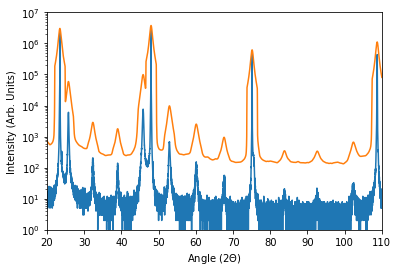

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# BeautifulSoup XML Parser
# API: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
from bs4 import BeautifulSoup

from google.colab import drive
drive.mount('/content/drive')
infile = '/content/drive/My Drive/Mundy Group/Three Muskateers Group/Code/test.xrdml'

# converts xrdml file into BeautifulSoup object
def convertToBS(filename):
  with open(filename,'r') as file:
    file_input = file.read()
  return BeautifulSoup(file_input)

# get 2Theta start and end positions
def get2Theta(filename):
  soup = convertToBS(filename)
  return [float(soup.startposition.string),float(soup.endposition.string)]

# get intensities of tth scan 
def getIntensities(filename):
  soup = convertToBS(filename)
  return [float(intensity) for intensity in soup.intensities.string.split()]

# get id 
def getID(filename):
  soup = convertToBS(filename)
  return soup.id.string

# create dictionary of 2Theta and intensity values
def createDict(filename):
  d = {}
  [tth_beg,tth_end] = get2Theta(filename)
  intensities = getIntensities(filename)
  tth = tth_beg
  incr = (tth_end - tth_beg) / (len(intensities) - 1)
  for i in intensities:
    d[tth] = i
    tth = tth + incr
  return d


#TODO: Data Analysis
# Resolve Peaks (Maxima)

def gaussianFunc(x,x0,sigma):
  """Return a numpy array gaussian distribution."""
  return np.exp(-(x-x0) ** 2 / (2 * sigma ** 2))

def lorentzianFunc(x,x0,tau):
  """Return a numpy array lorentzian distribution."""
  return (1 / np.pi) * (1/2 * tau) / ((x-x0) ** 2 + (1/2*tau) ** 2)

def getwidth_incr(x,sigma,std):
  """Return the fwhm and incr for the Smooth function."""
  fwhm = sigma * np.sqrt(8 * np.log(2))
  incr = x[1] - x[0]
  ind_incr = int(round(std*fwhm/incr))
  return (ind_incr,fwhm)

def Smooth(x,y,sigma,std,weightG,weightL):
  """Returns the gaussian/lorenztian smoothed data."""
  smoothed_vals = np.zeros(y.shape)
  incr,fwhm = getwidth_incr(x,sigma,std)
  x = np.pad(x,incr)
  y = np.pad(y,incr)

  for i in range(len(x)-2*incr):
    gaussian = gaussianFunc(x[i:i+2*incr],x[i+incr],sigma)
    gaussian = gaussian/ sum(gaussian)
    lorentzian = lorentzianFunc(x[i:i+2*incr],x[i+incr],fwhm)
    smoothed_vals[i] = sum(weightG * y[i:i+2*incr] * gaussian + weightL * y[i:i+2*incr] * lorentzian)
  return smoothed_vals

def fourierSeries(x,y,r):
  L = (x[-1] - x[0])
  dx = x[1] - x[0]
  A0 = np.sum(y * np.ones_like(x)) * dx
  fFs = A0/2
  A = np.zeros(r)
  B = np.zeros(r)
  for i in range(r):
    A[i] = np.sum(y * np.cos(np.pi*(i+1)*x/L)) * dx
    B[i] = np.sum(y * np.sin(np.pi*(i+1)*x/L)) * dx
    fFs = fFs + A[i]*np.cos(np.pi*(i+1)*x/L) + B[i]*np.sin(np.pi*(i+1)*x/L)
  plt.semilogy(x,fFs)


#TODO: Data Output
def plotSemilogy(x,y):
  plt.semilogy(x,y)
  plt.semilogy(x,Smooth(x_vals,y_vals,0.3,2,0.5,0.5))
  plt.xlabel(r'Angle (2$\Theta$)')
  plt.ylabel(r'Intensity (Arb. Units)')
  plt.xlim([20,110])
  plt.ylim([1e0,1e7])

tth = createDict(infile)
x_vals,y_vals = np.array(list(tth.keys())),np.array(list(tth.values()))
# Semilogy Graph
plotSemilogy(x_vals,y_vals)
#fourierSeries(x_vals,gaussianSmooth(x_vals,y_vals,0.3,2),200)
